# Analyzing F1 Data Using Neo4j

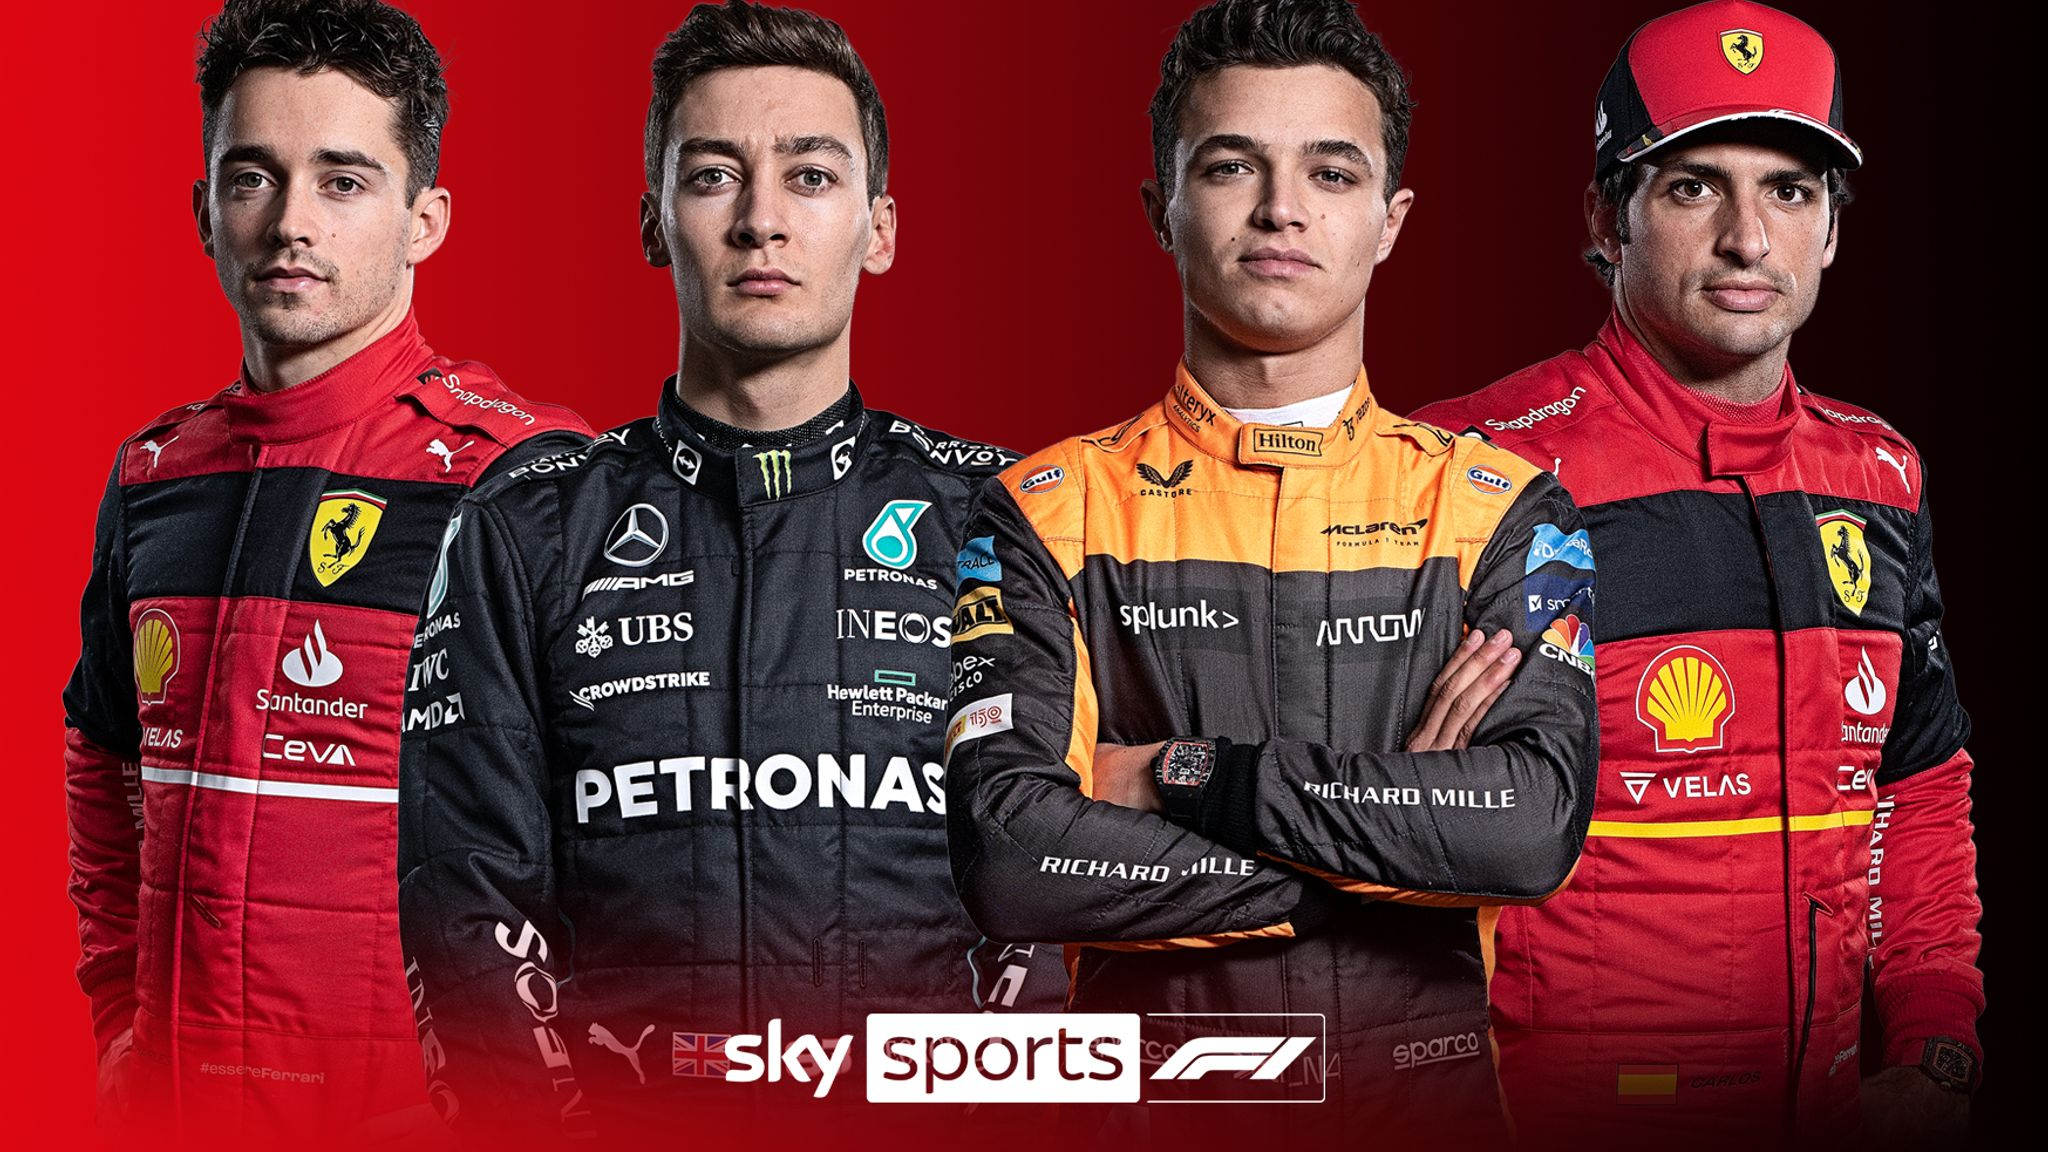

Install neo4j and import the essential libraries.

In [1]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 4.2 MB/s eta 0:00:00


In [2]:
import neo4j
from neo4j import GraphDatabase
import pandas
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Credentials for connectiong to the database in aura neo4j.

In [3]:
URI = "neo4j+s://e4b06f6d.databases.neo4j.io"
AUTH = ("neo4j", "SQjPaQXG9mpqi6ulxIXeTHF-QyJy1RK-ePRUFuLnfSM")

## Query1: Driver Championship Final Rank by Year

With this query, we can retrieve the final driver championship rankings for any desired year. The year can be changed dynamically by modifying the `year` variable below.



In [132]:
year = 1999 # change this value [1950 to 2024]

In [133]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(:Race)<-[ds:DRIVER_STAND]-(d:Driver)
    WHERE s.year = $year
    RETURN DISTINCT d.forename AS driverName, d.surname AS driverSurname, MAX(ds.points) AS points
    ORDER BY points DESC
    """,
    year=year,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [134]:
df

,driverName,driverSurname,points
0,Mika,Häkkinen,76
1,Eddie,Irvine,74
2,Heinz-Harald,Frentzen,54
3,David,Coulthard,48
4,Michael,Schumacher,44
5,Ralf,Schumacher,35
6,Rubens,Barrichello,21
7,Johnny,Herbert,15
8,Giancarlo,Fisichella,13
9,Mika,Salo,10


We can dynamically visualize the final driver standings in a histogram.

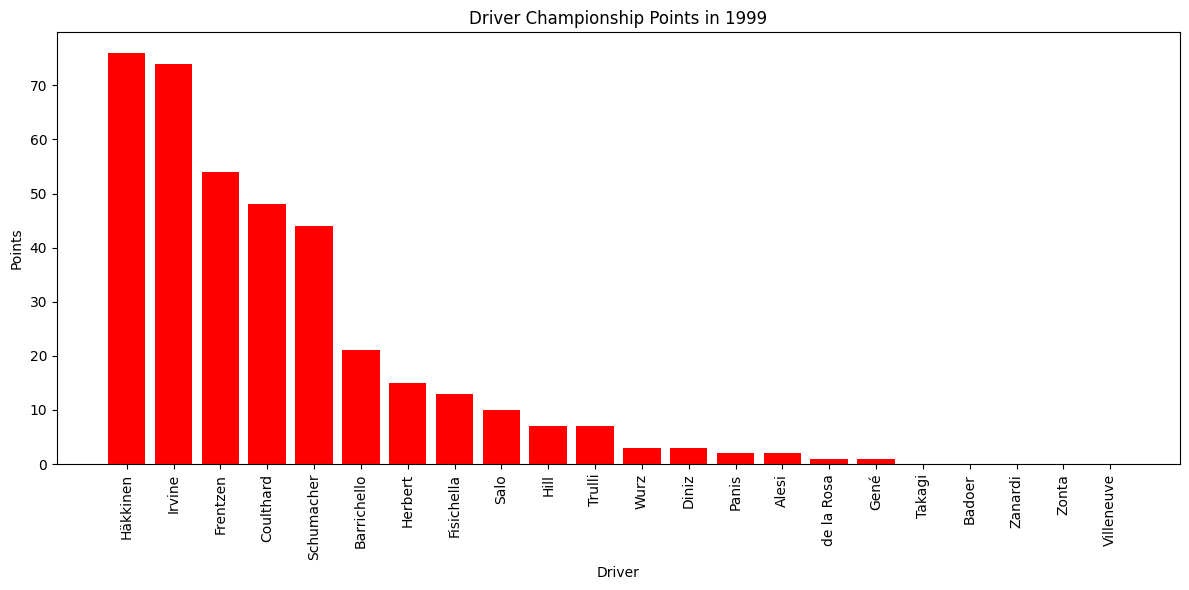

In [135]:
plt.figure(figsize=(12, 6))
plt.bar(df["driverSurname"], df["points"], color="red")
plt.xticks(rotation=90)
plt.title(f"Driver Championship Points in {year}")
plt.xlabel("Driver")
plt.ylabel("Points")
plt.tight_layout()
plt.show()

## Query2: Constructor Championship Final Rank by Year

With this query, we can retrieve the final constructor championship rankings for any desired year. The year can be changed dynamically by modifying the `year` variable below.

In [22]:
year = 2020 # change this value [1950 to 2024]

In [26]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(:Race)<-[cs:CONSTRUCTOR_STAND]-(c:Constructor)
    WHERE s.year = $year
    RETURN DISTINCT c.name AS constructor, MAX(cs.points) AS points
    ORDER BY points DESC
    """,
    year=year,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [27]:
df

,constructor,points
0,Mercedes,573
1,Red Bull,319
2,McLaren,202
3,Racing Point,195
4,Renault,181
5,Ferrari,131
6,AlphaTauri,107
7,Alfa Romeo,8
8,Haas F1 Team,3
9,Williams,0


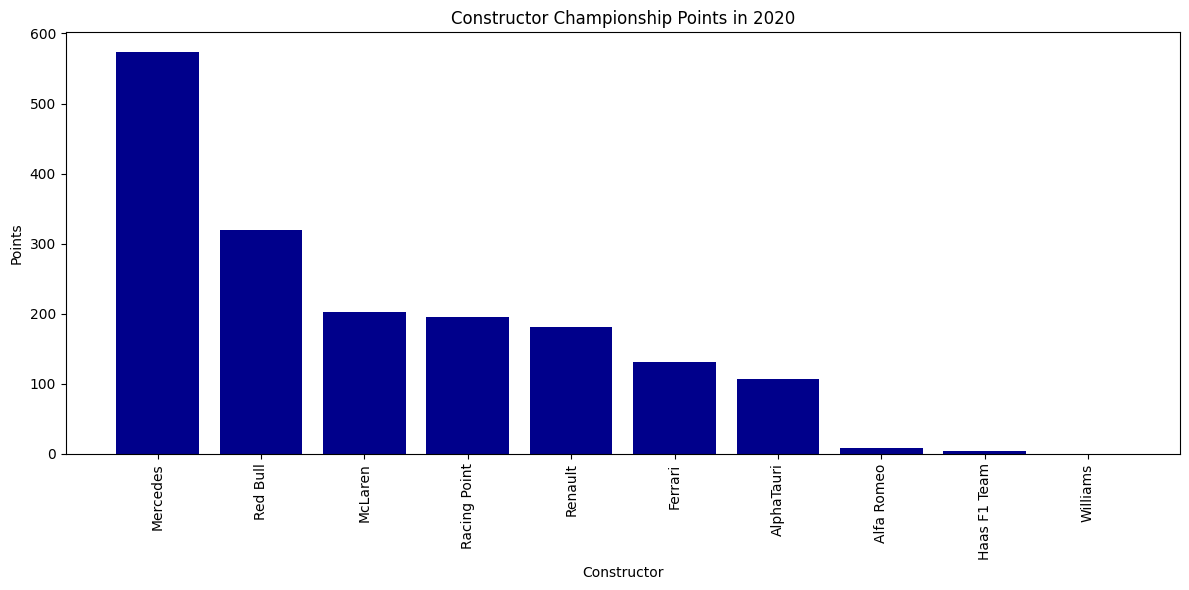

In [28]:
plt.figure(figsize=(12, 6))
plt.bar(df["constructor"], df["points"], color="darkblue")
plt.xticks(rotation=90)
plt.title(f"Constructor Championship Points in {year}")
plt.xlabel("Constructor")
plt.ylabel("Points")
plt.tight_layout()
plt.show()

## Query3: Driver Championship for Each Season

In [145]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(r:Race)<-[ds:DRIVER_STAND]-(d:Driver)
    WITH s, d.forename AS driverForename, d.surname AS driverSurname, MAX(ds.points) AS totalPoints
    ORDER BY totalPoints DESC
    WITH s, COLLECT({driverForename: driverForename, driverSurname: driverSurname, points: totalPoints}) AS standsPerYear
    WITH s, standsPerYear[0] AS champPerYear
    RETURN s.year AS Season,
           champPerYear.driverForename AS driverName,
           champPerYear.driverSurname AS driverSurname,
           champPerYear.points AS points
    ORDER BY Season DESC
    LIMIT $limit // eliminate this row to get all drivers champion for every season
    """,
    limit=15, # change this value to see more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [146]:
df

,Season,driverName,driverSurname,points
0,2024,Max,Verstappen,255
1,2023,Max,Verstappen,575
2,2022,Max,Verstappen,454
3,2021,Max,Verstappen,395
4,2020,Lewis,Hamilton,347
5,2019,Lewis,Hamilton,413
6,2018,Lewis,Hamilton,408
7,2017,Lewis,Hamilton,363
8,2016,Nico,Rosberg,385
9,2015,Lewis,Hamilton,381


## Query4: Constructor Championship for Each Season

In [147]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(r:Race)<-[cs:CONSTRUCTOR_STAND]-(c:Constructor)
    WITH s, c.name AS constructorName, MAX(cs.points) AS totalPoints
    ORDER BY totalPoints DESC
    WITH s, COLLECT({constructor: constructorName, points: totalPoints}) AS standsPerYear
    WITH s, standsPerYear[0] AS champPerYear
    RETURN s.year AS Season,
           champPerYear.constructor AS constructor,
           champPerYear.points AS points
    ORDER BY Season DESC
    LIMIT $limit // delete this row to get all records
    """,
    limit=15, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [148]:
df

,Season,constructorChamp,points
0,2024,Red Bull,373
1,2023,Red Bull,860
2,2022,Red Bull,759
3,2021,Mercedes,613
4,2020,Mercedes,573
5,2019,Mercedes,739
6,2018,Mercedes,655
7,2017,Mercedes,668
8,2016,Mercedes,765
9,2015,Mercedes,703


## Query5: Number of Championships per Driver

In [40]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(r:Race)<-[ds:DRIVER_STAND]-(d:Driver)
    WITH s, d.forename AS driverForename, d.surname AS driverSurname, MAX(ds.points) AS totalPoints
    ORDER BY totalPoints DESC
    WITH s, COLLECT({driverForename: driverForename, driverSurname: driverSurname, points: totalPoints}) AS standsPerYear
    WITH standsPerYear[0] AS champPerYear
    RETURN champPerYear.driverForename AS driverName,
           champPerYear.driverSurname AS driverSurname,
           COUNT(*) AS championships
    ORDER BY championships DESC
    """,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [41]:
df

,driverName,driverSurname,championships
0,Lewis,Hamilton,7
1,Michael,Schumacher,7
2,Juan,Fangio,5
3,Max,Verstappen,4
4,Sebastian,Vettel,4
5,Alain,Prost,4
6,Ayrton,Senna,3
7,Nelson,Piquet,3
8,Niki,Lauda,3
9,Jackie,Stewart,3


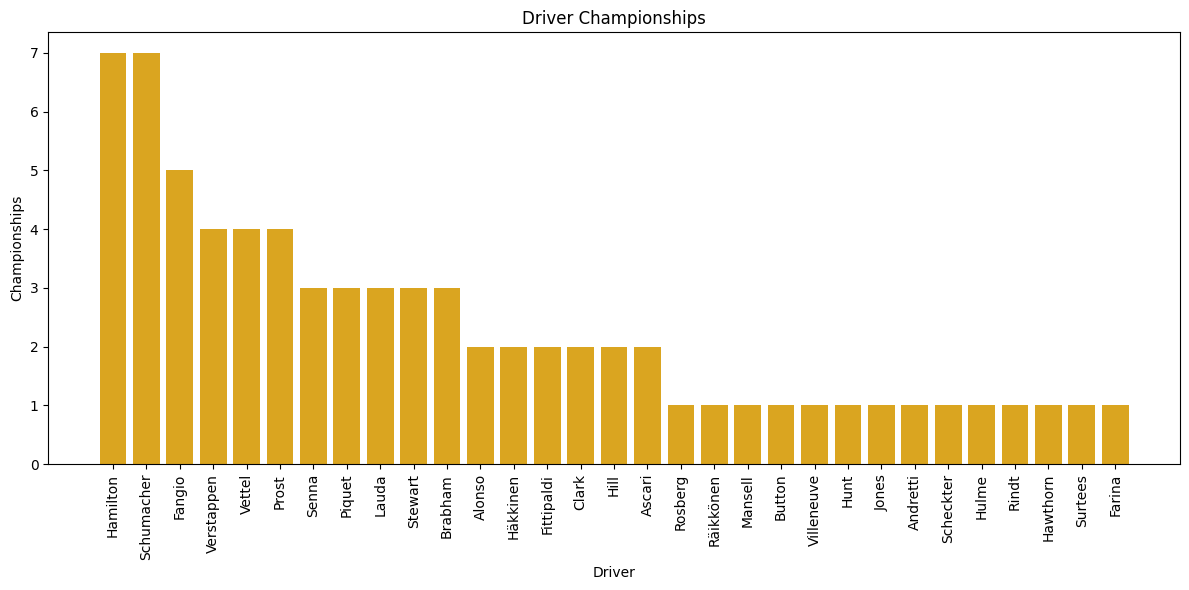

In [42]:
plt.figure(figsize=(12, 6))
plt.bar(df["driverSurname"], df["championships"], color="goldenrod")
plt.xticks(rotation=90)
plt.title(f"Driver Championships")
plt.xlabel("Driver")
plt.ylabel("Championships")
plt.tight_layout()
plt.show()

## Query6: Number of Championships Won by a Specific Constructor

This query provides all the seasons where the selected constructor won the championships.

In the 2007 Formula 1 season, McLaren initially scored 218 points in the Constructors' Championship. However, due to their involvement in the "Spygate" controversy, the team was disqualified from the Constructors' Championship, and their points were excluded from the final standings. This disqualification is not reflected in the database, which doesn't record the championship as being won by Ferrari, granting McLaren an additional Constructors' Championship for that year.

In [171]:
constructor = 'Ferrari' # Mercedes, McLaren, Alpine F1 Team, Williams, ...

In [172]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(r:Race)<-[cs:CONSTRUCTOR_STAND]-(c:Constructor)
    WITH s, c.name AS constructorName, MAX(cs.points) AS totalPoints
    ORDER BY totalPoints DESC
    WITH s, COLLECT({constructor: constructorName, points: totalPoints}) AS standsPerYear
    WITH s, standsPerYear[0] AS champPerYear
    WHERE champPerYear.constructor = $constructor
    WITH s, champPerYear AS constructorChampYear
    RETURN s.year AS Season,
           constructorChampYear.constructor AS ConstructorChamp,
           constructorChampYear.points AS Points
    ORDER BY Season DESC
    """,
    constructor=constructor,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [173]:
df

,Season,ConstructorChamp,Points
0,2008,Ferrari,172
1,2004,Ferrari,262
2,2003,Ferrari,158
3,2002,Ferrari,221
4,2001,Ferrari,179
5,2000,Ferrari,170
6,1999,Ferrari,128
7,1983,Ferrari,89
8,1982,Ferrari,74
9,1979,Ferrari,113


## Query7: Driver Champions with the Minimum Gap to the Second Place

Seasons in Formula 1 where the points allocation system changed include:  

1. **1950-1959**: Points awarded to the top five finishers (8-6-4-3-2) with 1 point for the fastest lap.  
2. **1960-1990**: Several adjustments, including points for the top six finishers (9-6-4-3-2-1).  
3. **1991-2002**: Points for the top six finishers increased for the winner (10-6-4-3-2-1).  
4. **2003-2009**: Points expanded to the top eight finishers (10-8-6-5-4-3-2-1).  
5. **2010-Present**: Major change to reward more finishers (25-18-15-12-10-8-6-4-2-1) for the top ten places.  

Considering these periods, we can determine the appropriate starting and ending time frames for analyzing the Driver Champions with the Minimum Gap to the Second Place.

In [193]:
starting_year = 2010 # 2003, 1991, 1960, 1950
ending_year = 2024 # 2009, 2002, 1990, 1959

In [194]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(r:Race)<-[ds:DRIVER_STAND]-(d:Driver)
    WHERE r.year >= $starting_year AND r.year <= $ending_year
    WITH s, d.forename AS driverForename, d.surname AS driverSurname, MAX(ds.points) AS totalPoints
    ORDER BY totalPoints DESC
    WITH s, collect({driverForename: driverForename, driverSurname: driverSurname, points: totalPoints}) AS standsPerYear
    WITH s, standsPerYear[0] AS champion, standsPerYear[1] AS runnerUp
    RETURN s.year AS season,
          champion.driverForename + " " + champion.driverSurname AS champion,
          runnerUp.driverForename + " " + runnerUp.driverSurname AS runnerUp,
          champion.points - runnerUp.points AS pointsGap
    ORDER BY pointsGap ASC
    """,
    starting_year=starting_year,
    ending_year=ending_year,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [195]:
df

,season,champion,runnerUp,pointsGap
0,2012,Sebastian Vettel,Fernando Alonso,3
1,2010,Sebastian Vettel,Fernando Alonso,4
2,2016,Nico Rosberg,Lewis Hamilton,5
3,2021,Max Verstappen,Lewis Hamilton,8
4,2017,Lewis Hamilton,Sebastian Vettel,46
5,2015,Lewis Hamilton,Nico Rosberg,59
6,2014,Lewis Hamilton,Nico Rosberg,67
7,2024,Max Verstappen,Lando Norris,84
8,2019,Lewis Hamilton,Valtteri Bottas,87
9,2018,Lewis Hamilton,Sebastian Vettel,88


## Query8: Most Wins at a Single Circuit by a Single Driver

This query returns each distinct circuit's most wins by a single driver, including cases where multiple drivers share the record for the most wins at a circuit.

In [239]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (c:Circuit)-[:HOLD]->(r:Race)<-[ds:DRIVER_STAND]-(d:Driver)
    WHERE ds.position = 1
    WITH c.name AS circuit, d.surname AS driver, COUNT(d) AS wins
    ORDER BY circuit, wins DESC
    WITH circuit, MAX(wins) AS maxWins, collect({driver: driver, wins: wins}) AS driverWins
    UNWIND driverWins AS dw
    WITH circuit, maxWins, dw
    WHERE dw.wins = maxWins
    RETURN circuit, dw.driver AS driver, dw.wins AS wins
    ORDER BY wins DESC
    """,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [237]:
df

,circuit,driver,wins
0,Circuit de Spa-Francorchamps,Hamilton,9
1,Autodromo Nazionale di Monza,Hamilton,8
2,Circuit Gilles Villeneuve,Schumacher,8
3,Circuit de Monaco,Schumacher,8
4,Circuit de Nevers Magny-Cours,Schumacher,8
...,...,...,...
98,Monsanto Park Circuit,Brabham,1
99,Pescara Circuit,Fangio,1
100,Riverside International Raceway,Brabham,1
101,Sebring International Raceway,Brabham,1


We can visualize the number of most wins at a single circuit for each driver based on the records above.

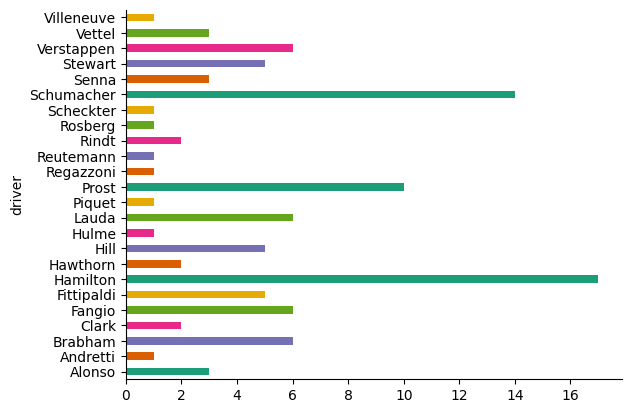

In [238]:
df.groupby('driver').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Query9: Most Starts in Pole Position Without Winning

In [43]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (d:Driver)-[:DELIVER]->(r:Result)
    WHERE r.startingPosition = 1 AND r.positionOrder <> 1
    RETURN  d.forename AS driverName,
            d.surname AS driverSurname,
            COUNT(r) AS Value
    ORDER BY Value DESC
    LIMIT $limit // delete this row to get all records
    """,
    limit=50, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [44]:
df

,driverName,driverSurname,Value
0,Lewis,Hamilton,43
1,Ayrton,Senna,36
2,Michael,Schumacher,28
3,Sebastian,Vettel,26
4,Nelson,Piquet,19
5,Jim,Clark,19
6,Charles,Leclerc,19
7,Juan,Fangio,16
8,René,Arnoux,16
9,Mika,Häkkinen,16


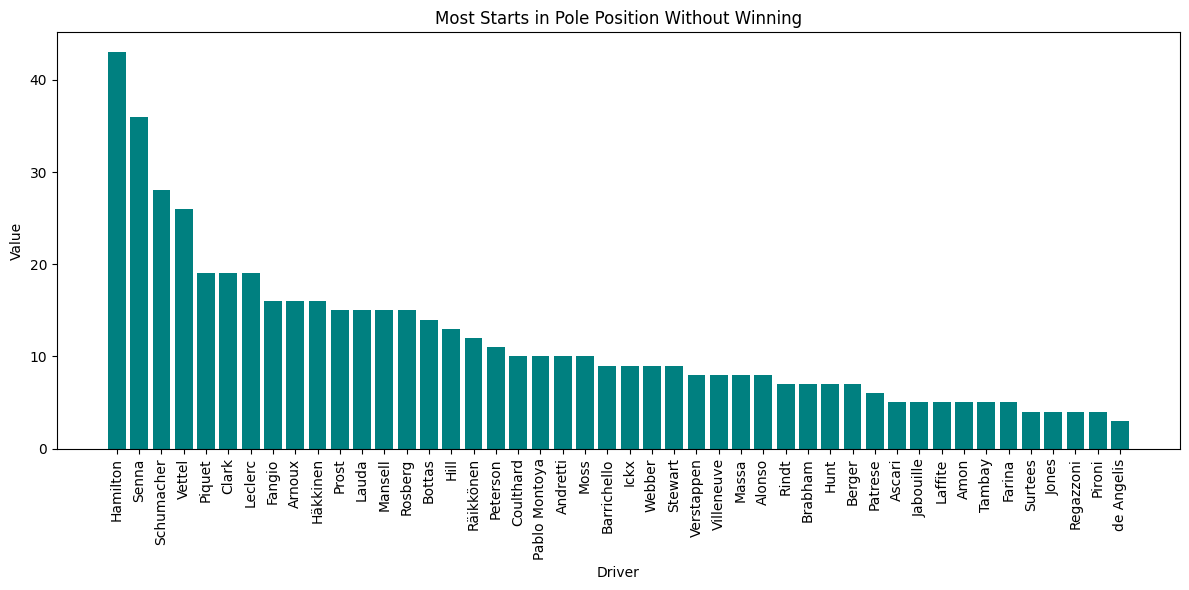

In [45]:
plt.figure(figsize=(12, 6))
plt.bar(df["driverSurname"], df["Value"], color="teal")
plt.xticks(rotation=90)
plt.title("Most Starts in Pole Position Without Winning")
plt.xlabel("Driver")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

## Query10: Circuit with the Highest Win Rate Starting from Pole Position

In [52]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (c:Circuit)-[:HOLD]->(r:Race)<-[:TAKE_PLACE]-(res:Result)
    WHERE res.startingPosition = 1
    WITH c,
        COUNT(res) AS totalRaces,
        SUM(CASE WHEN res.startingPosition = 1 AND res.position = 1 THEN 1 ELSE 0 END) AS winsFromPole
    WHERE totalRaces >= 15
    RETURN c.name AS Circuit,
          winsFromPole * 1.0 / totalRaces AS WinPercentage
    ORDER BY WinPercentage DESC
    """,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [53]:
df

,Circuit,WinPercentage
0,Circuit de Barcelona-Catalunya,0.705882
1,Yas Marina Circuit,0.666667
2,Circuit Paul Ricard,0.611111
3,Shanghai International Circuit,0.588235
4,Suzuka Circuit,0.529412
5,Circuit Gilles Villeneuve,0.488372
6,Hockenheimring,0.486486
7,Bahrain International Circuit,0.476190
8,Sepang International Circuit,0.473684
9,Circuit Park Zandvoort,0.454545


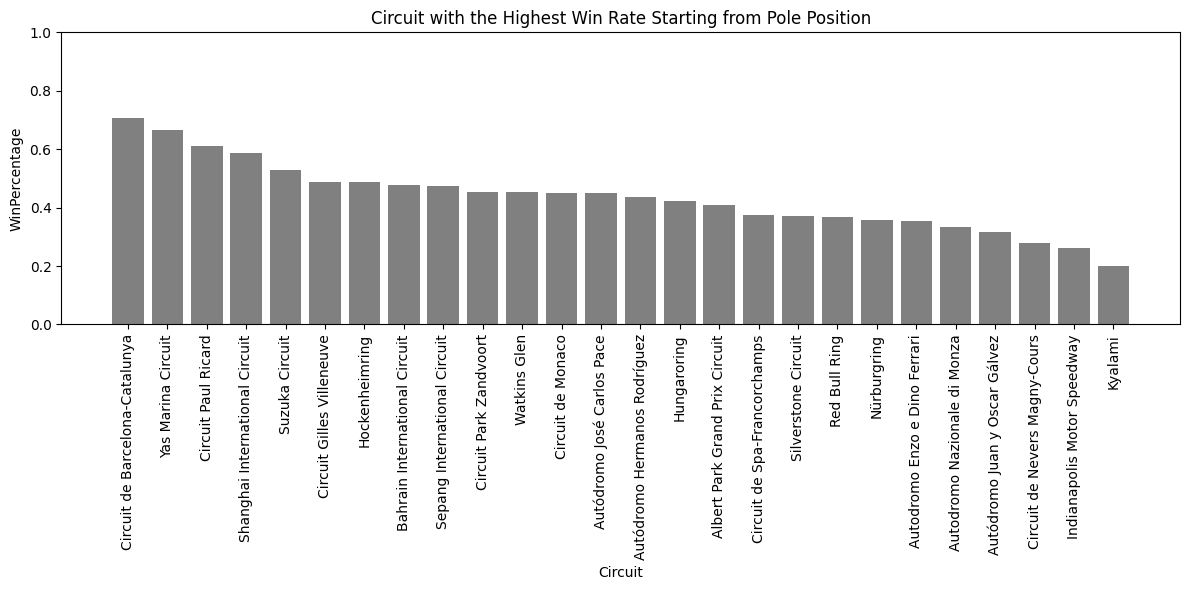

In [54]:
plt.figure(figsize=(12, 6))
plt.bar(df["Circuit"], df["WinPercentage"], color="grey")
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.title("Circuit with the Highest Win Rate Starting from Pole Position")
plt.xlabel("Circuit")
plt.ylabel("WinPercentage")
plt.tight_layout()
plt.show()

## Query11: Youngest Driver Champions List, Considering the Final Race of the Season

In [57]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (s:Season)-[:PLAN]->(r:Race)
    WITH s, MAX(r.date) AS lastRaceDate
    MATCH (s)-[:PLAN]->(r:Race)<-[ds:DRIVER_STAND]-(d:Driver)
    WITH s, d.forename AS driverForename, d.surname AS driverSurname, d.dob AS driverDob, MAX(ds.points) AS totalPoints, lastRaceDate
    ORDER BY totalPoints DESC
    WITH s,
        COLLECT({ driverForename: driverForename, driverSurname: driverSurname, driverDob: driverDob, points: totalPoints}) AS standsPerYear,
        lastRaceDate
    WITH s, standsPerYear[0] AS champPerYear, lastRaceDate
    WITH s, champPerYear.driverForename AS forename, champPerYear.driverSurname AS surname, champPerYear.driverDob AS dob,
        duration.between(champPerYear.driverDob, lastRaceDate).years AS ageAtWinYears,
        duration.between(champPerYear.driverDob, lastRaceDate).months AS ageAtWinMonths,
        duration.between(champPerYear.driverDob, lastRaceDate).days AS ageAtWinDays,
        champPerYear.points AS points
    ORDER BY ageAtWinYears ASC, ageAtWinMonths ASC, ageAtWinDays ASC
    RETURN forename, surname, dob, ageAtWinYears AS years, ageAtWinMonths AS months, ageAtWinDays AS days, points, s.year AS season
    LIMIT $limit // delete this row to get all records
    """,
    limit=10, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [58]:
df

,forename,surname,dob,years,months,days,points,season
0,Sebastian,Vettel,1987-07-03,23,280,11,256,2010
1,Lewis,Hamilton,1985-01-07,23,285,26,98,2008
2,Max,Verstappen,1997-09-30,24,290,12,395,2021
3,Fernando,Alonso,1981-07-29,24,290,17,133,2005
4,Sebastian,Vettel,1987-07-03,24,292,24,392,2011
5,Max,Verstappen,1997-09-30,25,301,21,454,2022
6,Fernando,Alonso,1981-07-29,25,302,23,134,2006
7,Sebastian,Vettel,1987-07-03,25,304,22,281,2012
8,Emerson,Fittipaldi,1946-12-12,25,309,26,61,1972
9,Michael,Schumacher,1969-01-03,25,310,10,92,1994


## Query12: Wins from the Furthest Back on the Starting Grid

In [59]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (d:Driver)-[:DELIVER]->(r:Result)
    WHERE r.positionOrder = 1
    WITH d, r.startingPosition - r.positionOrder AS gridGap, r.raceId AS races
    MATCH (race:Race) WHERE race.raceId = races
    RETURN d.forename AS driverName, d.surname AS driverSurname, gridGap, race.name AS race
    ORDER BY gridGap DESC
    LIMIT $limit // delete this row to get all records
    """,
    limit=50, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [60]:
df

,driverName,driverSurname,gridGap,race
0,John,Watson,21,United States Grand Prix West
1,Bill,Vukovich,18,Indianapolis 500
2,Rubens,Barrichello,17,German Grand Prix
3,Kimi,Räikkönen,16,Japanese Grand Prix
4,John,Watson,16,Detroit Grand Prix
5,Michael,Schumacher,15,Belgian Grand Prix
6,Jackie,Stewart,15,South African Grand Prix
7,Fernando,Alonso,14,Singapore Grand Prix
8,Jenson,Button,13,Hungarian Grand Prix
9,Johnny,Herbert,13,European Grand Prix


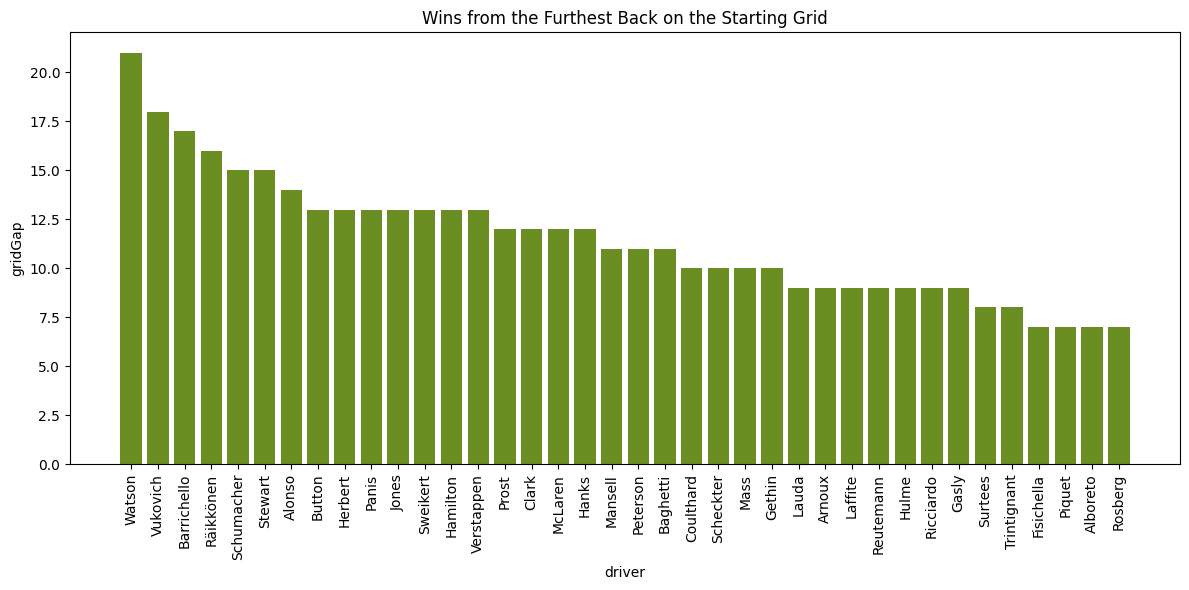

In [61]:
plt.figure(figsize=(12, 6))
plt.bar(df["driverSurname"], df["gridGap"], color="olivedrab")
plt.xticks(rotation=90)
plt.title("Wins from the Furthest Back on the Starting Grid")
plt.xlabel("driver")
plt.ylabel("gridGap")
plt.tight_layout()
plt.show()

## Query13: Highest percentage of podium finishes in a season

In [91]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (d:Driver)-[:DELIVER]->(res:Result)-[:TAKE_PLACE]->(r:Race)<-[:PLAN]-(s:Season)
    WHERE res.positionOrder IN [1, 2, 3]
    WITH s, d, COUNT(res) AS podiumFinishes
    MATCH (s:Season)-[:PLAN]->(r:Race)
    WITH s, d, podiumFinishes, COUNT(r) AS totalRaces
    WITH s, d, (toFloat(podiumFinishes) / totalRaces) * 100 AS podiumPercentage, podiumFinishes, totalRaces
    RETURN
        s.year AS seasonYear,
        d.forename AS forename,
        d.surname AS surname,
        podiumPercentage,
        podiumFinishes,
        totalRaces
    ORDER BY podiumPercentage DESC
    """,
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [92]:
df

,seasonYear,forename,surname,podiumPercentage,podiumFinishes,totalRaces
0,2002,Michael,Schumacher,100.000000,17,17
1,2023,Max,Verstappen,95.454545,21,22
2,1963,Jim,Clark,90.000000,9,10
3,2011,Sebastian,Vettel,89.473684,17,19
4,2015,Lewis,Hamilton,89.473684,17,19
...,...,...,...,...,...,...
849,2021,George,Russell,4.545455,1,22
850,2021,Daniel,Ricciardo,4.545455,1,22
851,2022,Lando,Norris,4.545455,1,22
852,2023,Esteban,Ocon,4.545455,1,22


Given the complete list of highest percentage wins in a season by a single driver (over 850 results), we can observe the trend of percentages in the following plot.

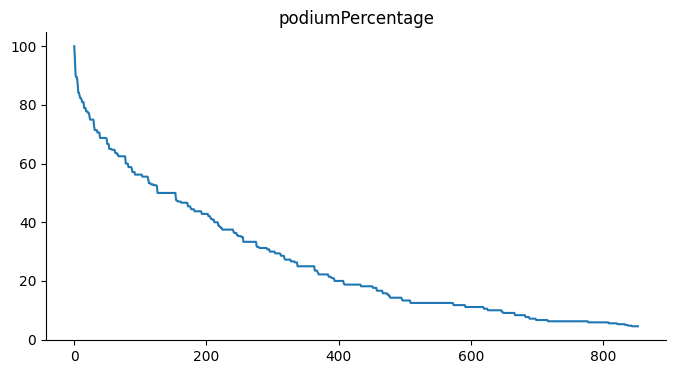

In [90]:
df['podiumPercentage'].plot(kind='line', figsize=(8, 4), title='podiumPercentage')
plt.gca().spines[['top', 'right']].set_visible(False)

## Query14: Most races before scoring a podium finish

In [75]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (d:Driver)-[:DELIVER]->(res:Result)-[:TAKE_PLACE]->(r:Race)<-[:PLAN]-(s:Season)
    WITH d, collect({race: r, result: res}) AS finishes
    WHERE ANY(finish IN finishes WHERE finish.result.positionOrder IN [1, 2, 3])
    UNWIND finishes AS finish
    WITH d, finish.race AS race, finish.result.positionOrder AS positionOrder, finish.race.date AS raceDate
    ORDER BY raceDate ASC
    WITH d, collect({race: race, positionOrder: positionOrder}) AS orderedRaces
    WITH d, orderedRaces,
        REDUCE(
            s = { val: 0, podium: 1 },
            r IN orderedRaces |
            CASE
                WHEN r.positionOrder IN [1, 2, 3] AND s.podium = 1 THEN
                    { val: s.val, podium: 0 }
                ELSE
                    { val: s.val + s.podium * 1, podium: s.podium }
            END
        ) AS racesBeforePodium

    RETURN d.forename AS forename, d.surname AS surname, racesBeforePodium.val AS racesBeforePodium
    ORDER BY racesBeforePodium DESC
    LIMIT $limit // delete this row to get all records
    """,
    limit=50, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [76]:
df

,forename,surname,racesBeforePodium
0,Carlos,Sainz,100
1,Martin,Brundle,97
2,Mika,Salo,72
3,Johnny,Herbert,69
4,Nicola,Larini,69
5,Jenson,Button,68
6,Pedro,de la Rosa,66
7,Esteban,Ocon,65
8,Gianni,Morbidelli,61
9,Felipe,Massa,57


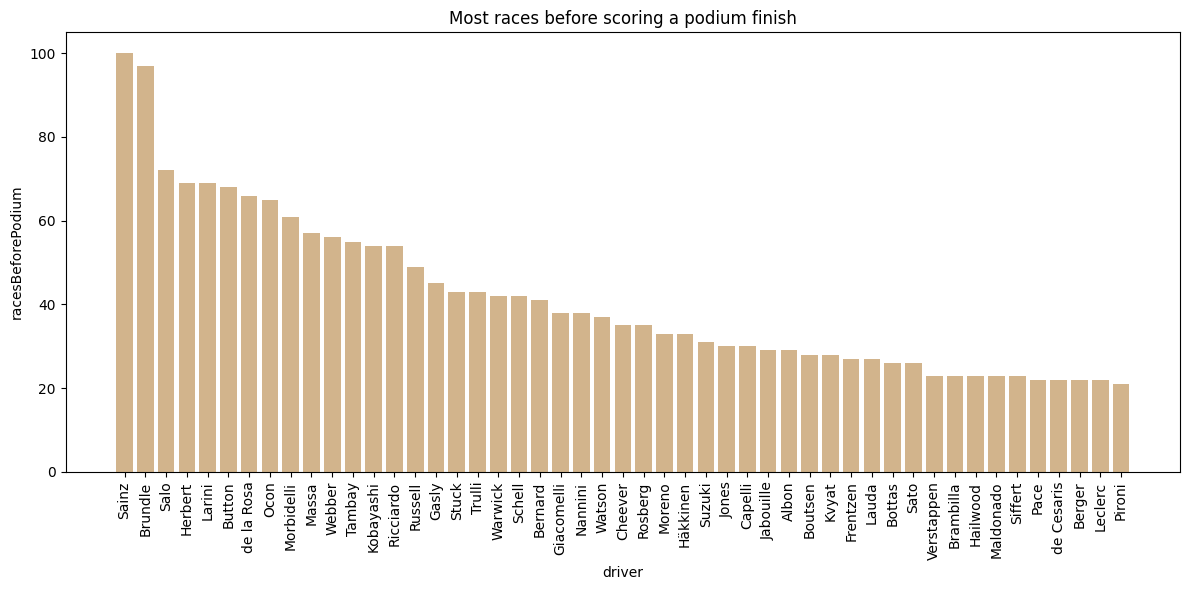

In [77]:
plt.figure(figsize=(12, 6))
plt.bar(df["surname"], df["racesBeforePodium"], color="tan")
plt.xticks(rotation=90)
plt.title("Most races before scoring a podium finish")
plt.xlabel("driver")
plt.ylabel("racesBeforePodium")
plt.tight_layout()
plt.show()

## Query15: Drivers with the Most Wins

In [99]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (r:Result) WHERE r.positionOrder = 1
    WITH r
    MATCH (d:Driver)-[:DELIVER]->(r)
    RETURN d.surname AS driverSurname,
          d.forename AS driverForename,
          d.nationality AS driverNationality,
          COUNT(r) AS wins
    ORDER BY wins DESC
    LIMIT $limit // delete this row to get all records
    """,
    limit=50, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [97]:
df

,driverSurname,driverForename,driverNationality,wins
0,Hamilton,Lewis,British,104
1,Schumacher,Michael,German,91
2,Verstappen,Max,Dutch,61
3,Vettel,Sebastian,German,53
4,Prost,Alain,French,51
5,Senna,Ayrton,Brazilian,41
6,Alonso,Fernando,Spanish,32
7,Mansell,Nigel,British,31
8,Stewart,Jackie,British,27
9,Clark,Jim,British,25


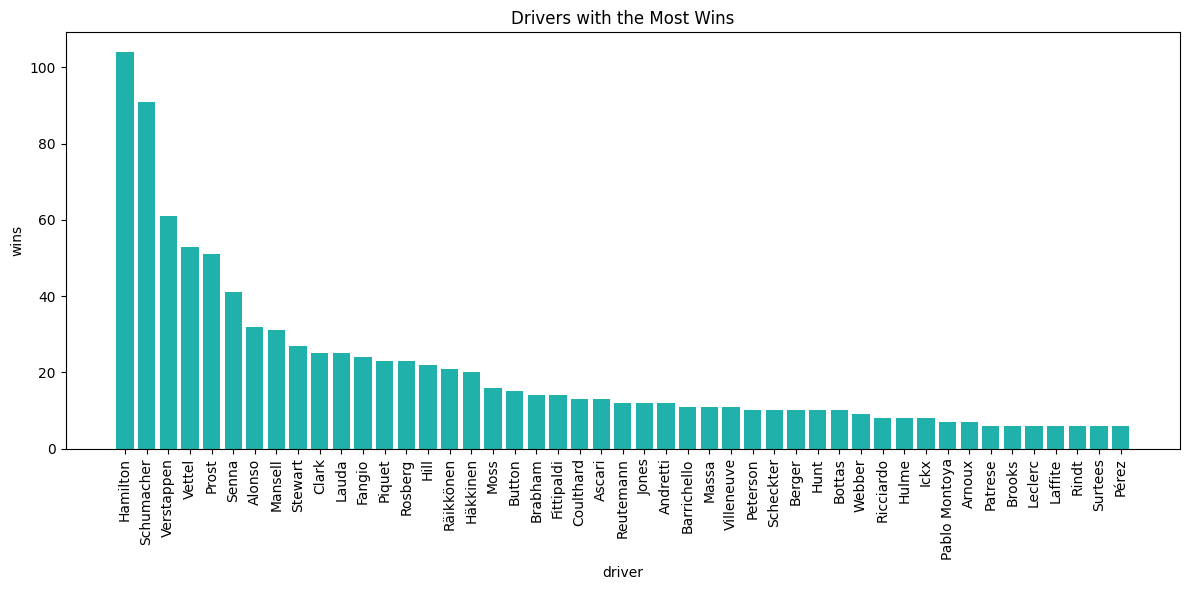

In [98]:
plt.figure(figsize=(12, 6))
plt.bar(df["driverSurname"], df["wins"], color="lightseagreen")
plt.xticks(rotation=90)
plt.title("Drivers with the Most Wins")
plt.xlabel("driver")
plt.ylabel("wins")
plt.tight_layout()
plt.show()

## Query16: Percentage of Wins (Minimum 15 Starts)

In [103]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (d:Driver)-[:DELIVER]->(result:Result)
    WHERE result.startingPosition <> 0
    WITH d, COUNT(result) AS raceForDriver
    WHERE raceForDriver >= 15
    MATCH (d)-[:DELIVER]->(result:Result)
    WHERE result.positionOrder = 1
    WITH d, raceForDriver, COUNT(result) AS wins
    RETURN d.surname AS driverSurname,
          d.forename AS driverForename,
          wins,
          raceForDriver,
          (toFloat(wins) / raceForDriver) * 100 AS winPercentage
    ORDER BY winPercentage DESC
    LIMIT $limit // delete this row to get all records
    """,
    limit=50, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [136]:
df

,driverName,driverSurname,points
0,Mika,Häkkinen,76
1,Eddie,Irvine,74
2,Heinz-Harald,Frentzen,54
3,David,Coulthard,48
4,Michael,Schumacher,44
5,Ralf,Schumacher,35
6,Rubens,Barrichello,21
7,Johnny,Herbert,15
8,Giancarlo,Fisichella,13
9,Mika,Salo,10


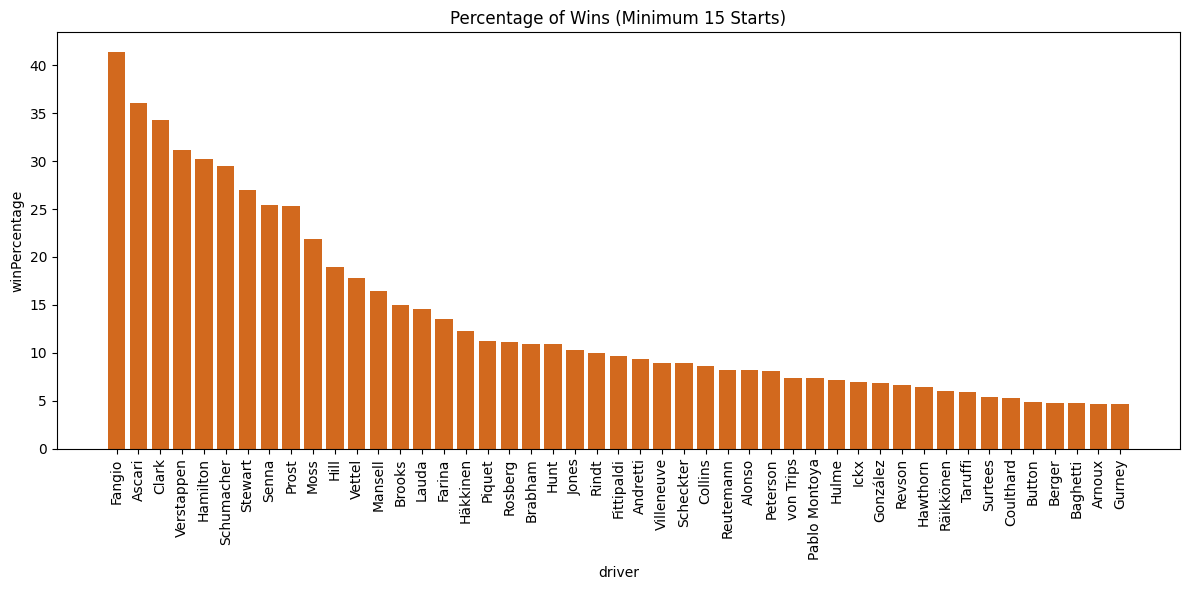

In [102]:
plt.figure(figsize=(12, 6))
plt.bar(df["driverSurname"], df["winPercentage"], color="chocolate")
plt.xticks(rotation=90)
plt.title("Percentage of Wins (Minimum 15 Starts)")
plt.xlabel("driver")
plt.ylabel("winPercentage")
plt.tight_layout()
plt.show()

## Query17: Drivers with the Most Consecutive Wins

In [107]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (result:Result)-[:TAKE_PLACE]->(race:Race)
    WHERE result.positionOrder = 1
    WITH result, race
    ORDER BY race.date
    MATCH (driver:Driver)-[:DELIVER]->(result)
    WITH collect({driver: driver, date: race.date}) AS results
    WITH REDUCE(
        acc = {combined: [], currentStreak: 0, lastDriver: null},
        res IN results |
        CASE
            WHEN acc.lastDriver = res.driver THEN
                {
                    combined: acc.combined[0..-1] + [{driver: acc.lastDriver, streak: acc.currentStreak + 1}],
                    currentStreak: acc.currentStreak + 1,
                    lastDriver: res.driver
                }
            ELSE
                {
                    combined: acc.combined + [{driver: res.driver, streak: 1}],
                    currentStreak: 1,
                    lastDriver: res.driver
                }
        END
    ) AS result
    WITH result.combined AS streaksWithDrivers
    UNWIND streaksWithDrivers AS streakData
    RETURN streakData.driver.driverId AS driverId,
          streakData.driver.surname AS driverSurname,
          streakData.driver.forename AS driverForename,
          streakData.driver.nationality AS driverNationality,
          streakData.streak AS streak
    ORDER BY streak DESC
    LIMIT $limit // delete this row to get all records
    """,
    limit=10, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [108]:
df

,driverId,driverSurname,driverForename,driverNationality,streak
0,830,Verstappen,Max,Dutch,10
1,20,Vettel,Sebastian,German,9
2,830,Verstappen,Max,Dutch,9
3,647,Ascari,Alberto,Italian,7
4,3,Rosberg,Nico,German,7
5,30,Schumacher,Michael,German,7
6,30,Schumacher,Michael,German,6
7,95,Mansell,Nigel,British,5
8,1,Hamilton,Lewis,British,5
9,373,Clark,Jim,British,5


## Query18: Most Races Won with a Single Constructor

In [114]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
  df = driver.execute_query(
    """
    MATCH (d:Driver)-[:DELIVER]->(r:Result)<-[:DELIVER]-(c:Constructor)
    WHERE r.positionOrder = 1
    RETURN d.forename AS driverForename, d.surname AS drivesurname, c.name AS constructor, COUNT(r) AS wins
    ORDER BY wins DESC
    LIMIT $limit // delete this row to get all records
    """,
    limit=20, # change this value to get more records
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
  )

In [115]:
df

,driverForename,drivesurname,constructor,wins
0,Lewis,Hamilton,Mercedes,83
1,Michael,Schumacher,Ferrari,72
2,Max,Verstappen,Red Bull,61
3,Sebastian,Vettel,Red Bull,38
4,Ayrton,Senna,McLaren,35
5,Alain,Prost,McLaren,30
6,Nigel,Mansell,Williams,28
7,Nico,Rosberg,Mercedes,23
8,Damon,Hill,Williams,21
9,Lewis,Hamilton,McLaren,21
